# P-Wave Pressure Simulation

P-Wave or Primary Wave or Pressure Wave is one of the two main seismic waves. It can travel around gases, solids, and fluids. It moves back and forth (compressional). It has higher velocity than S-wave, thereby it is the first wave that is recorded in the seismograph when earthquake occurs.  

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import matplotlib.animation as animation

### Acoustic Wave Equation
$$
\frac{1}{c^2(x,y)}\frac{\partial^2p(x,y,t)}{\partial t^2} = \nabla \cdot \left( \frac{1}{\rho(x,y)} \nabla p(x,y,t) \right) + S(x,y,t)
$$

Where:
- $p(x,y,t)$ is the acoustic pressure field at position $(x, y)$ and time $t$ in $Pa$,
- $c(x,y)$ is the local wave speed or velocity in $m/s$,
- $\rho(x,y)$ is the density in $kg/m^3$.
- $S(x,y,t)$ is the source of the seismic wave (Ricker wavelet) 

In [19]:
# Simulation Area Parameter
NX, NY = 200, 200  #Grid size
XMIN, XMAX = 0.0, 2000.0  
YMIN, YMAX = 0.0, 2000.0  

# Animation Plot Parameter
PLOT_EVERY = 5  

In [20]:
# For Laplacian Approximation using FDM
DX = (XMAX - XMIN) / NX  # Spatial step (m)
DT = 0.001  # Time step (s)
NT = 900  

# Wave speed model (m/s) - Simple one layer model
VEL = np.ones((NX, NY)) * 3000.0  # Base velocity (rock)

# Wave speed model (m/s) - Simple two-layer model
# VEL = np.ones((NX, NY)) * 3000.0  # Base velocity (water)
# VEL[NX//2:, :] = 3000.0  # Higher velocity layer (rock)

# Density model (kg/m³)
# For real world Earth structure, this is not supposed to be 
# constant because the Earth is not homogeneous or 
# anisotropic (properties vary based on direction)
RHO = np.ones((NX, NY)) * 1000.0

In [21]:
phi = np.zeros((NX, NY))  # Pressure field (current)
psi = np.zeros((NX, NY))  # Pressure field (previous)
vx = np.zeros((NX, NY))  # x-component of particle velocity
vy = np.zeros((NX, NY))  # y-component of particle velocity

In [22]:
# Damping or Absorbing Boundary
ABL_WIDTH = 20 #grid point on simulation area's edge for absorbing
damping = np.ones((NX, NY)) 

# pressure on top and bottom get scaled down from 1.0 to 0.9
damping[:ABL_WIDTH, :] = np.linspace(0.9, 1.0, ABL_WIDTH)[:, np.newaxis]
damping[-ABL_WIDTH:, :] = np.linspace(1.0, 0.9, ABL_WIDTH)[:, np.newaxis]

# preserve the strongest damping when overlapping in left and right edge
damping[:, :ABL_WIDTH] = np.minimum(damping[:, :ABL_WIDTH], np.linspace(0.9, 1.0, ABL_WIDTH))
damping[:, -ABL_WIDTH:] = np.minimum(damping[:, -ABL_WIDTH:], np.linspace(1.0, 0.9, ABL_WIDTH))

### Ricker Wavelet
Ricker wavelet is the second derivative of a Gaussian function. It can mimic real seismic source, so we can conduct our numerical simulation based on it. The standard formula in the time domain is

$$
    A(t) = \left( 1-2\pi^2 f_0^2 t^2 \right) e^{- \pi^2 f_0^2 t^2}
$$
where
- $f_0$ is the peak frequency in Hertz

In [23]:
# Seismic source (Ricker wavelet at center)
def ricker_wavelet(t, f0=20.0):
    return (1.0 - 2.0*(np.pi*f0*t)**2) * np.exp(-(np.pi*f0*t)**2)

source_x, source_y = NX//4, NY//2  # Source position
source_times = np.arange(NT) * DT # Time values

# Pressure amplitude
# The peak will occur on t which is source_times-0.1 or in
# 0.1 seconds instead right at t=0, so that it is smoother
source_amp = ricker_wavelet(source_times - 0.1, f0=20.0) * 1e6  

### Discretization
We write down the second order wave equation into a system of first order PDEs by using $v_x, v_y$, and $p$.

$$
\frac{\partial v_x}{\partial t} = -\frac{1}{\rho} \frac{\partial p}{\partial x} \\ 
\frac{\partial v_y}{\partial t} = -\frac{1}{\rho} \frac{\partial p}{\partial x} \\ 
\frac{\partial p}{\partial t} = - \rho c^2 \left( \frac{\partial v_x}{\partial x} + \frac{\partial v_y}{\partial y} \right)
$$

For velocity, the approximation is
$$
    v_x^{n+1} = v_x^{n} - \frac{\Delta t}{\rho} \cdot \frac{\partial p}{\partial x}
$$\\
Using central difference FDM, $\frac{\partial p}{\partial x} = \frac{p_{i+1,j} - p_{i-1,j}}{2 \Delta x}$ 

Meanwhile, for pressure, based on the acoustic wave equation (rewritten below)
$$
\frac{1}{c^2(x,y)}\frac{\partial^2p(x,y,t)}{\partial t^2} = \nabla \cdot \left( \frac{1}{\rho(x,y)} \nabla p(x,y,t) \right) + S(x,y,t)
$$

We can simplify it to 
$$
\frac{\partial^2 p}{\partial t^2} = c^2 \nabla^2 p 
$$
We do not use $\rho$ here because we assume that it is constant for simplicity. (See Last Markdown for more info).

The discretization of the second order derivation using central differences (leapfrog scheme):
$$
\frac{\partial^2 p}{\partial t^2} \approx \frac{p_{i,j}^{n+1} - 2p_{i,j}^{n} + p_{i,j}^{n-1}}{\Delta t^2}
$$

The discretization of the Laplacian using central differences:
$$
\nabla^2 p \approx \frac{p_{i+1,j}+p_{i-1,j} + p_{i,j+1} + p_{i,j-1} - 4p_{i,j}}{\Delta x^2}
$$

Substituting it in the simplified wave equation, we got 
$$
\frac{p_{i,j}^{n+1} - 2p_{i,j}^{n} + p_{i,j}^{n-1}}{\Delta t^2} = c^2 \cdot \frac{p_{i+1,j}^n+p_{i-1,j}^n + p_{i,j+1}^n + p_{i,j-1}^n - 4p_{i,j}^n}{\Delta x^2} 
$$

Next, we can get the $p_{i,j}^{n+1}$
$$
p_{i,j}^{n+1} = 2p_{i,j}^{n} - p_{i,j}^{n-1} + \left( \frac{c^2 \Delta t^2}{\Delta x^2}
    \right) \left( p_{i+1,j}^n+p_{i-1,j}^n + p_{i,j+1}^n + p_{i,j-1}^n - 4p_{i,j}^n \right)
$$

In [24]:
def update_wave(n):
    """Update the wave field for one time step"""
    global phi, psi, vx, vy
    
    # Add pressure injection/amplitude (S) to pressure field
    if n < len(source_amp):
        phi[source_x, source_y] += source_amp[n]
    
    # Update particle velocities (vx, vy)
    # vx[1:-1, 1:-1] -= (DT/RHO[1:-1, 1:-1]) * (phi[2:, 1:-1] - phi[:-2, 1:-1]) / (2*DX)
    # vy[1:-1, 1:-1] -= (DT/RHO[1:-1, 1:-1]) * (phi[1:-1, 2:] - phi[1:-1, :-2]) / (2*DX)
    
    # Update pressure field based on the final p_{i,j}^{n+1} formula
    phi_new = phi.copy()
    phi_new[1:-1, 1:-1] = (
        2*phi[1:-1, 1:-1] - psi[1:-1, 1:-1] +
        (VEL[1:-1, 1:-1]**2 * DT**2 / DX**2) * (
            
            phi[2:, 1:-1] + phi[:-2, 1:-1] +
            phi[1:-1, 2:] + phi[1:-1, :-2] -
            4*phi[1:-1, 1:-1]
        )
    )
    # apply damping
    phi_new *= damping

    # Update fields
    psi = phi.copy()
    phi = phi_new.copy()

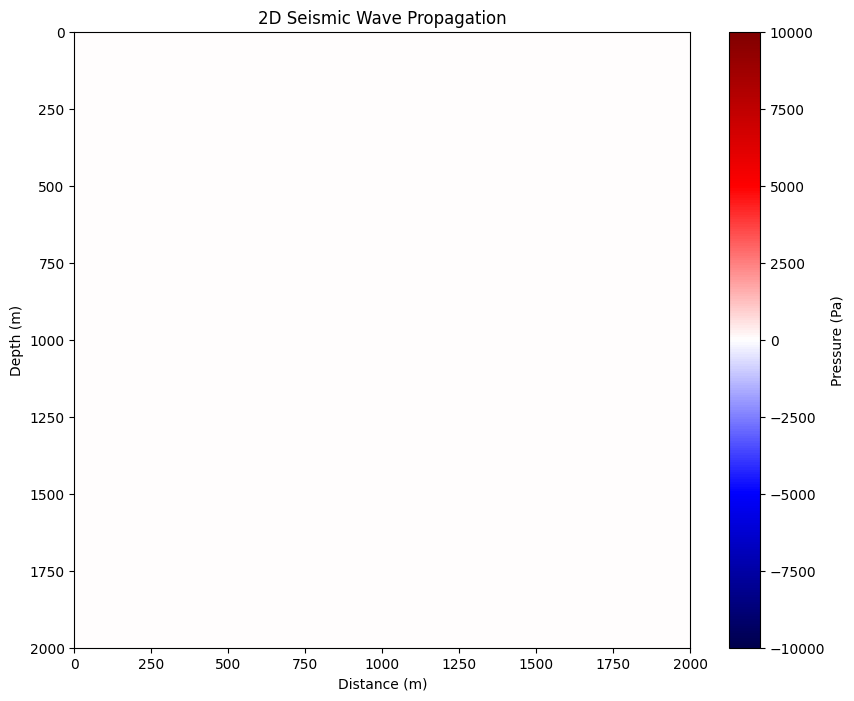

In [ ]:
# Create figure
fig, ax = plt.subplots(figsize=(10, 8))
img = ax.imshow(phi.T, extent=[XMIN, XMAX, YMAX, YMIN], 
                cmap='seismic', vmin=-1e4, vmax=1e4)
plt.colorbar(img, label='Pressure (Pa)')
ax.set_title("2D Seismic Wave Propagation")
ax.set_xlabel("Distance (m)")
ax.set_ylabel("Depth (m)")

plt.show()

In [ ]:
def update(frame):
    """Update function for animation"""
    for _ in range(PLOT_EVERY):
        update_wave(frame * PLOT_EVERY + _)
    
    img.set_array(phi.T)
    return [img]

ani = FuncAnimation(fig, update, frames=NT//PLOT_EVERY, interval=50, blit=True)

In [27]:
ffmpeg_writer = animation.FFMpegWriter(fps=20)
ani.save('test_p_wave1.mp4', writer=ffmpeg_writer)

##### NOTE
For waves in a solid, the speed can be determined by this formula:
$$
c = \sqrt{ \frac{Y}{\rho} }
$$

where
- $Y$ is the Young's modulus or stiffness in $N/m^2$.
- $\rho$ is the density in $kg/m^3$.

For fluid, the formula is also the same, but it use $B$ (Bulk Modulus) instead. 

The reason why $\rho$ is not counted in the simulation is because $\rho$ is already implicitly included in $c^2$ as shown in the above formula. 

If we want to include $\rho$, then we have to compute $\nabla \left(\frac{1}{\rho} \nabla p \right)$ as the equation below.
$$
    \frac{\partial}{\partial x} \left( \frac{1}{\rho} \frac{\partial p}{\partial x} \right) + \frac{\partial}{\partial y} \left( \frac{1}{\rho} \frac{\partial p}{\partial y} \right)
$$
This involves more partial derivatives and will increase our computation time significantly.